In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
# Standard linear model
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize



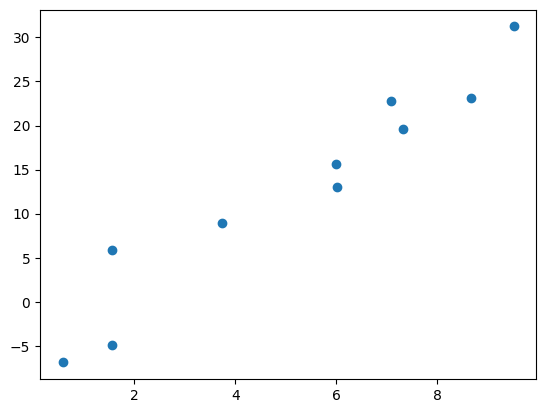

In [10]:
# Bayesian Regression
np.random.seed(42)
x = np.random.uniform(0, 10, 10)
y = 3 * x + np.random.normal(0, 5, 10)

test = np.random.uniform(0, 5, 1000)
min_val = float('inf')
min_index = None
for i in range(len(test)):
    pred = test[i] * x
    error = y - pred
    if np.sum(error) < min_val:
        min_val = np.sum(error)
        min_index = i

# Plot the data points
plt.scatter(x, y)
plt.show()

In [11]:


lm = LinearRegression(fit_intercept=False)
lm.fit(x.reshape(-1, 1), y)
print("Coefficients:")
print(lm.coef_)

Coefficients:
[2.79015326]


In [12]:
# Maximum Likelihood Estimate
def likelihood(beta, sd):
    y_pred = beta * x
    res = y - y_pred
    l = norm.logpdf(res, loc=0, scale=sd).sum()
    return l


def ml_likelihood(params):
    beta = params[0]
    sd = params[1]
    if sd <= 0:
        return -np.inf
    y_pred = beta * x
    res = y - y_pred
    l = norm.logpdf(res, loc=0, scale=sd).sum()
    return -l

In [13]:


result = minimize(ml_likelihood, [1, 1], method="Nelder-Mead")
print("Maximum Likelihood Estimates:")
print(result.x)

Maximum Likelihood Estimates:
[2.79016478 4.59534662]


In [14]:
# Bayesian Regression
def posterior_estimate(beta, sd, prior_beta, prior_sd):
    l = likelihood(beta, sd) + prior_beta, prior_sd
    return l

In [16]:
# Brute force result

# Set a strong prior of beta = 3 with a standard deviation = 0.1
betas = np.random.uniform(-10, 15, 10000)
beta_p = norm.logpdf(betas, loc=5, scale=3)

# SDs prior
sds = np.random.uniform(10, 30, 10000)
sds_p = uniform.logpdf(sds, loc=10, scale=20)


In [17]:
# Set up parameters
iterations = 20000
burnin = 2000

# Define support functions
def jump_function(x_in):
    b_proposal = np.random.normal(x_in[0], 1)
    sd_proposal = np.random.uniform(x_in[1] - 0.5, x_in[1] + 0.5)
    if b_proposal < 0:
        b_proposal = 0.01
    if sd_proposal < 15:
        sd_proposal = 15
    return {"b_proposal": b_proposal, "sd_proposal": sd_proposal}

def prior_likelihood(params):
    return np.log(norm.pdf(params[0], 5, 3)) + np.log(norm.pdf(params[1], 10, 30))

def posterior_mh(beta, sd):
    return likelihood(beta, sd) + prior_likelihood([beta, sd])



In [18]:
# Set up the parameter matrix
parameters = np.empty((iterations, 5))
parameters[:, :] = np.nan
parameters[0, :] = [betas[0], sds[0], beta_p[0], sds_p[0], np.nan]

# Run the Metropolis-Hastings algorithm
for i in range(iterations-1):
    # Calculate the posterior for the current iteration
    parameters[i, 4] = posterior_mh(parameters[i, 0], parameters[i, 1])
  
    # Find a proposal point
    proposals = jump_function(parameters[i, :2])
  
    # Calculate the posterior for the proposal
    proposal_likelihood = posterior_mh(proposals['b_proposal'], proposals['sd_proposal'])
  
    acceptance_ratio = np.exp(proposal_likelihood - parameters[i, 4])
  
    # If the proposal likelihood is greater, always accept the proposal
    if acceptance_ratio > 1:
        parameters[i+1, :2] = proposals['b_proposal'], proposals['sd_proposal']
    else:
        # Otherwise, sometimes accept and sometimes explore
        p = np.random.uniform(0, 1)
        if p > (1 - acceptance_ratio):
            parameters[i+1, :2] = proposals['b_proposal'], proposals['sd_proposal']
        else:
            parameters[i+1, :2] = parameters[i, :2]



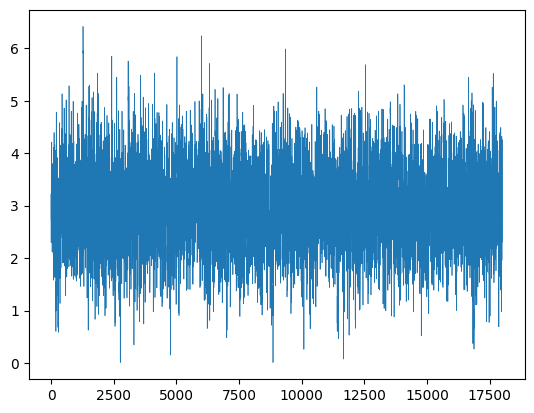

In [21]:
# Plot the "chain"
plt.plot(parameters[burnin:iterations, 0], linewidth=0.5)

(array([   6.,    7.,   22.,   36.,   97.,  177.,  278.,  477.,  732.,
        1029., 1257., 1495., 1757., 1904., 1799., 1791., 1469., 1054.,
         864.,  694.,  457.,  254.,  170.,   86.,   49.,   14.,    8.,
          14.,    0.,    3.]),
 array([0.01      , 0.2234868 , 0.43697361, 0.65046041, 0.86394721,
        1.07743401, 1.29092082, 1.50440762, 1.71789442, 1.93138122,
        2.14486803, 2.35835483, 2.57184163, 2.78532843, 2.99881524,
        3.21230204, 3.42578884, 3.63927564, 3.85276245, 4.06624925,
        4.27973605, 4.49322285, 4.70670966, 4.92019646, 5.13368326,
        5.34717006, 5.56065687, 5.77414367, 5.98763047, 6.20111727,
        6.41460408]),
 <BarContainer object of 30 artists>)

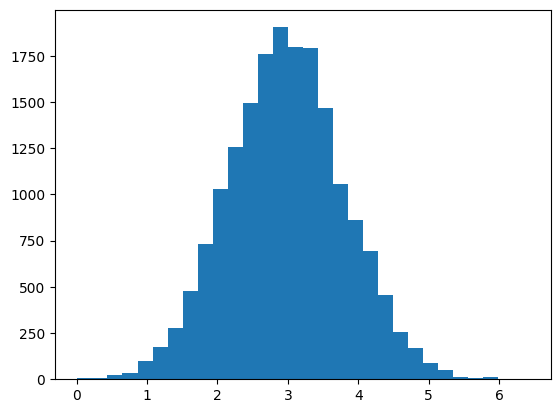

In [20]:
# Plot a histogram of the Beta posterior
plt.hist(parameters[burnin:iterations, 0], bins=30)

In [19]:
# Calculate and print the mean of the Beta posterior
print(np.mean(parameters[burnin:iterations, 0]))

2.9768718421439275
